In [1]:
!pip install transformers

In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Sat May 25 17:52:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import pandas as pd

df = pd.read_csv("/content/sample_data/train.csv")

df['All'] = df['Context'] + ' ' + df['Response']

df.drop(['Context', 'Response'], axis=1, inplace=True)

print(df)


                                                    All
0     I'm going through some things with my feelings...
1     I'm going through some things with my feelings...
2     I'm going through some things with my feelings...
3     I'm going through some things with my feelings...
4     I'm going through some things with my feelings...
...                                                 ...
3507  My grandson's step-mother sends him to school ...
3508  My boyfriend is in recovery from drug addictio...
3509  The birth mother attempted suicide several tim...
3510  I think adult life is making him depressed and...
3511  I just took a job that requires me to travel f...

[3512 rows x 1 columns]


In [6]:
df.dropna(inplace=True) #remove NA values
bios = df.All.copy() #just use the main bio text in this example


<ipython-input-7-fa091b8c73b4>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

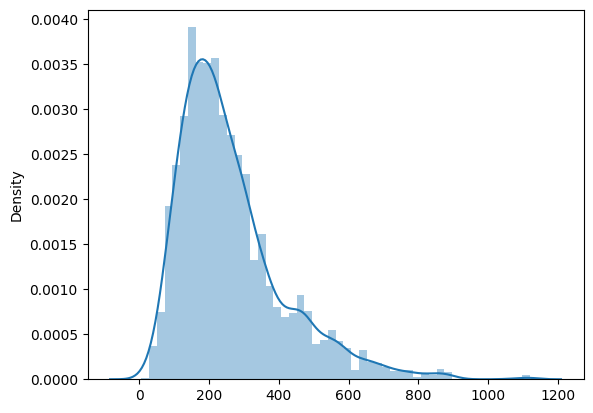

In [7]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [8]:
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.010547320410490307

In [9]:
np.average(doc_lengths)

263.21664766248574

In [10]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [12]:
batch_size = 2

In [13]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [14]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,157 training samples
  351 validation samples


In [15]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [16]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [21]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [23]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,579. Loss: 0.8435590267181396.   Elapsed: 0:00:48.
0:  bipartisan" the environment will, and the emotional environment is also potentially vulnerable to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,579. Loss: 1.0163408517837524.   Elapsed: 0:01:38.
0:  increasingS that it's the weather and how it works. If you don't know it, you are probably a little too stupid. I know many people will say something about your lack of interest and lack of interest in your current situations. Do you feel your future and past can be different to your current choices? If you do, do you not feel like you will feel similarly. Also, do you have suggestions about the various choices you are making? I don't want your future to be what you are seeing, and I want to see what you are thinking about in your present.   It's not what you are hoping, your future is the future. 
If you decide not to pursue what you are going to do and choose to have a family,  this will be your decision, so  you will decide which choice you wish your own family to take in the future. In an ideal world, you would have a family or you would have friends.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,579. Loss: 1.7008849382400513.   Elapsed: 0:02:30.
0: dayI'm gay and I wear only pink pajamas for school days. I'm a lifetime away from my family. Is that really okay?

This is an attempt to clarify your relationship with your therapist. Do you think this is something that needs clarification by your therapist?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,579. Loss: 1.0967216491699219.   Elapsed: 0:03:21.
0:  HangOur grandson was born here in our home. A lot of kids are born here and there. We are fortunate to have him here. But at the same time our child needs us. Our child needed us. He was very special. I am thankful for his loving and caring. He was brought home from school. We love him. We feel very lucky and that he has such a loving and caring mom who brings him home. We will never forgive the father for this cruel violation of our child's heart.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,579. Loss: 1.0118588209152222.   Elapsed: 0:04:13.
0:  foodsI live in my mom's home. I used to sleep in a mattress and pillows with my mom. Now I want a baby. I want to get pregnant on my own.

’Saying that is very much on the shelf. I have to get a good therapist. If I want to be an adult, I need to be able to give my mom some help. I am sure that she will work toward my goal.
Some kids have a really strong sense of selflessness and worth. And they also have a sense of who they are (or something) in the world, so there is a way to do this. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,579. Loss: 1.9329220056533813.   Elapsed: 0:05:06.
0:  trailMy husband and I have been together for seven years. Our primary concern for us is that there are other issues going on. I have an eating disorder. I am unable to walk, talk, or go anywhere, even with food. I have trouble sleeping, and my job involves working from home. My husband has been diagnosed with eating disorder and I have had a serious eating disorder for many years. However, as he is already disabled, my husband and I could not afford to continue a relationship without either being diagnosed with the other's eating disorder. My husband refuses to leave home without a prescription, so I cannot afford to take care of his son. My husband was diagnosed with a mental health disorder, so we have been together for seven years. At the beginning we were friends, but it soon became a problem. When I was diagnosed with a mental health disorder, he told me that he had no choice. My husband became very upset 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,579. Loss: 1.1513984203338623.   Elapsed: 0:05:59.
0: intendI can be more serious about my relationship than I was recently, and I'm currently dealing with both of those issues. I don't feel the romantic drama I experienced prior to my marriage with his wife has been one of his more pressing emotions. The couple is no longer together. But the loss of him as a couple will still affect everyone in the relationship. It will affect our relationship for years to come.   That is a loss that deserves to be addressed. I hope you are supportive and can continue to heal yourself from this difficult time. From a very humble point of view, I have known and learned from having had this relationship. So I hope you can feel good.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,579. Loss: 0.8254317045211792.   Elapsed: 0:06:51.
0:  surroundI was raped by a male friend in a domestic violence case. I am a total waste of time and resources, and I'm not the best guy for it. I have a total of 2 friends and one female co-worker. The only one who doesn't need the help is me, so how do I address this? I have a long history of depression and I have been happily married for almost 35 years. The past year has been filled with ups and downs, and I feel very alone and alone, as well as some very nasty and frightening events.I recently found that you may have a very limited role in influencing the way you live.  It has always seemed that you're not the best fit for the world, if not for yourself, then for your country.  But as far as I know your country isn a relatively small one.  Have you tried counseling? A counselor might make recommendations for you to go to counseling sessions.  If you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,579. Loss: 0.8857102990150452.   Elapsed: 0:07:44.
0:  reflexAfter being kicked out of a group of highschool peers after a fight, an girl has become an angry, jealous, controlling person in this high school. She is very young and does not appear to have a master's degree. She is in her early 20s and has a 4-year-old daughter. During our visit, I was wondering if she has any more issues, especially if she is a single parent or has less kids. After checking her out, I told her that she had no proof of any problem, but that she did have a boyfriend. In other words, we did not know who else had kids in school. After reviewing a few other factors, it made sense that she had no history of sexual abuse or abuse, so she has only had one friend since college, and it did not seem to bother her with any other children in her home.  Maybe the reason this girl wasn't a good fit in school was because she grew up with no other


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,579. Loss: 1.8019967079162598.   Elapsed: 0:08:37.
0:  displayI don’t like it when I cry in my hotel room. I was never really shy for my friends. I was very shy. I feel very scared of people I don’t like. Is this normal? Probably not. I don’t think that is normal. If it's something that is not necessarily healthy for you, I would recommend you talk with a therapist in your area. This is your chance to get to know each other better.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,579. Loss: 0.8580135107040405.   Elapsed: 0:09:29.
0:  pastorI am in my late 20s and I am making a habit of smoking marijuana, drinking, and almost always having more sexual desire than I need. It takes a lot of courage to give up smoking, but it will be easier on your mind than the other way around. As for drinking, you may want to see a doctor before setting up new habits. In general, smoking cigarettes and drinking is not good for you and may take some time to get past that. You may even need counseling before setting up new plans to smoke weed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,579. Loss: 0.6654436588287354.   Elapsed: 0:10:21.
0:  illicitI am a teenage girl, and my parents always seem to push me away because of my sexual identity and sexuality. I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.   I have a long history of depression and I’m beginning to have anxiety. I also have a history of depression and I’m beginning to have anxiety.   I have low self esteem but I’ve been happily married for almost 35 years.
  Is there anything I can do to address this? Absolutely. You have already addressed your struggles in your area and this has been a very difficult area for you and this is very important to address.  I suggest that you do your own research on this online at www.counseling-online.com/relationships/feminist-services/bred-daughters-sex/domestic-violence


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,579. Loss: 1.4021201133728027.   Elapsed: 0:11:14.
0:  LiberationI just broke up with my boyfriend for 13 years because he had no contact with me. I never wanted to.  I wanted the relationship to be over. I had always wanted sex, but it never happened. Now I’m almost divorced because I feel like he is trying to control me.
 I feel very hurt because I don't feel he is truly happy with me anymore, and I don’t know why. I just want him to know that he knows, and trust him enough to tell him. I just want him to stay with me. It will be important to see his maturity on his part. I would say here, if you see his mature maturity on your part, you don't have to be in a position to give him advice on how to handle this situation. There is nothing you can do about it; you can do whatever things you need to in order to feel better, and they will go a long way. I wish you the best


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,579. Loss: 0.8458513021469116.   Elapsed: 0:12:08.
0:  NamWhen I hear people talk I want to yell or be sad. I know I want to, but I can't deal with that. I hate it! I don't know what to do. How can I manage this better?  I want you to accept and care about your feelings and feelings. This is not a pleasant feeling, and you need to move on and learn how to manage these feelings.  If you want to start understanding how this feels for a short time, there is a lot of information available online and often it is not a good idea, but if you are in that kind of situation then I would recommend it, just take a minute here to know your needs and understand them.  For those that are looking to learn coping skills, I wonder if you have a book or book club. If you are looking for some strategies, then you could also go search for a therapist and start speaking directly with them, to learn some skills.  Also you could also find other


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,579. Loss: 1.0384581089019775.   Elapsed: 0:13:02.
0: IONWhat does a counselor do to help clients understand the problem? The counselor would like to give the client some specific tips on how they can best help themselves.  Counseling is a complex experience so many different ways to learn new skills that are beneficial to those in need.  One thing that I love about working with clients is that we can learn skills so that when we start the journey to building new skills we can feel connected to it all the time!  So it can be very helpful to find some strategies that make sense to you! 

  Average training loss: 1.45
  Training epoch took: 0:13:43

Running Validation...
  Validation Loss: 1.01
  Validation took: 0:00:28

======== Epoch 2 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,579. Loss: 0.6764436364173889.   Elapsed: 0:00:51.
0:  glimpseI was born a girl. My mother is always blocking me out of her house.  When my dad calls, she tells me she's afraid.  He doesn't like that.  He's scared of anything and acts like he doesn't believe me.  He sleeps and stays the night. Nothing is ever okay. Why not tell her? There's a better way. How do I tell her? You're born a girl with a mother who's constantly blocking you out. The only way to get through a house is to force her and her children out. But she doesn't keep her children isolated either, they need her as their model. I don't know why you're here. It sounds like you're trying to keep these tensions going. Have there been any changes in your sexual relationship since the birth of a child?If you live with mom in Texas, do you see her anywhere?Do you see any signs of a problem?I think it may be best if


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,579. Loss: 1.0726271867752075.   Elapsed: 0:01:44.
0:  LaureI have always wanted to fix my issues, especially my boyfriend. I spent a lot of my life trying to fix my issues, so it's never easy. He's always changing, and I think I've let him down. I don't think he's willing to listen. I don't believe he's willing to have honest conversations about his life, and I think he's doing everything by his own rules. He doesn't seem to know what he's doing wrong, but I don't think he's trying to change. Hi Texas,While I've never tried to get him to change, there are some things he's willing to work on and things you can try as well. My sense is he doesn't want to know what his future holds...and his attitude toward women is extremely hurtful. It's a shame that you've lost your boyfriend!Your boyfriend is in an unstable and confusing situation that puts you on the defensive. When you find yourself defending yourself, you need to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,579. Loss: 1.0199705362319946.   Elapsed: 0:02:37.
0: ismI'm obsessing about the people that make me crazy and I want to stop. It's hurting me so much I can't sleep. How can I cope? We're all different, all have different ways of behaving, and all have different rules for when we shouldn't be loud, loud, or loud. This is normal.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,579. Loss: 1.292298674583435.   Elapsed: 0:03:29.
0: ounWhat makes a healthy marriage last? What makes a healthy marriage last? It's a complex question. There are several groups that help people to answer the question, and I am not saying you can't just talk about it. Here are some things that a marriage can do that is both beneficial and healthy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,579. Loss: 0.7641922831535339.   Elapsed: 0:04:21.
0:  electionI think I've lost the mind, which I've already lost. I'm very sorry to hear about your loss.I'm very aware of that you seem to have a lot of issues with self-talk. It can be very disorienting and this can make sense to someone who is a good listener. If you catch yourself thinking something like: "Oh, no!" I don't understand what you mean when you say, "Oh, no". I don't think this could be really confusing if you are not so disoriented.I want to encourage you to not allow yourself to feel or feel so unidentifiable, and to seek out someone who is in a relationship with someone whom you truly care about.I hope this helps.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,579. Loss: 1.3103550672531128.   Elapsed: 0:05:13.
0:  crazyI've always been afraid of girls, but now I'm even afraid of being ugly. I get it! I can see that there's something wrong with me. How can I stop it? We all have thoughts of how others would look at us, like we're all beautiful. I am not going to deny that we're imperfect or imperfect, and I'm not going to deny that people are drawn to us all the time or to us just because we're different. We're just not real. I'm not a boy, I'm a girl; I never am. I look at a girl as if she doesn't exist.I don't have the same fears I have about being ugly as men have, which I imagine is great and real. You are just afraid to tell your friends.Your friend may think it's wrong for you to see her face, which is what you are trying to do in the first place.Maybe you want to be seen as beautiful, and you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,579. Loss: 0.3208800256252289.   Elapsed: 0:06:07.
0:  benchI am married, but I still live with my parents when I get home each morning. How do I make this work? This will give you an idea of what each of you wants.You know that "you can't change someone else, but you can change yourself".The truth is that having someone change is a hardwired part of life.So yes you can change and have more control over your emotions so you can focus on how you like other people, instead of how you are feeling toward yourself.The key is to be loving to others and not to change yourself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,579. Loss: 1.2386358976364136.   Elapsed: 0:06:59.
0:  incorporatedI'm dealing with depression after going through things that have made me crazy. I'm worried that I could hurt myself or cause problems. Paranoid, I'm always anxious to know what will happen if I do something stupid or silly.
    What should I do? It's a personal issue and you can never control what triggers it, especially if things are so bad.
   How do you get your feeling of depression? Have you spoken to your primary care physician? Do you have an opinion? I know what it is that can be going on, however, I wonder if you have an opinion as to whether it's "all or nothing".   If it's all or nothing, you are more likely to have depression.  I don't know what's going on with your depression, but I would want to know how long it has been going on and what you want to do about it to make sure it doesn't affect your daily living. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,579. Loss: 1.2498201131820679.   Elapsed: 0:07:53.
0: PeterHow do I stop the nightmares and flashbacks? The nightmares and flashbacks are quite unsettling for many people who have experienced them. Many people have experienced them over and over again. To begin therapy with these type of nightmares, you must recognize that they can be very disturbing at times and you must seek professional help to lessen your nightmares.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,579. Loss: 0.5956845879554749.   Elapsed: 0:08:45.
0: uringI start counseling/therapy in a few days (I'm freaking out) but my main fear is that I'll cry and embarrass myself, is it something to worry about? I’m scared. Hello. Thank you for your question.  If I was crying, I would be the first to cry in counseling. It’s a normal thing to do to ourselves.  Crying is normal for a lot of people.  It’s a normal time to be in therapy when things are really challenging.  Everyone has their unique unique story and it’s okay to cry.  I would encourage you to seek out another, something that works for you.  Love, Mirella Mag.  LCSW, LPCC, NCC  LCSW’s website


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,579. Loss: 0.8174778819084167.   Elapsed: 0:09:38.
0:  reproductiveHow do you know you have the right therapist for you? Should I give my therapist a call or does it have to be in a specific case? I'd say if you're not feeling comfortable asking yourself that, then probably you don't have the right one.  It's not that the particular therapist you're getting the help for is a bad idea.  It would probably be a good idea to discuss all these things before you make your decision.   The more you ask what's going on with your therapist and what matters most to you, the more comfortable you feel.   If I was your therapist I would never wish anyone harm.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,579. Loss: 0.5066797137260437.   Elapsed: 0:10:30.
0:  zoneI have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.    I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.
   I’ve never had counseling about any of this. Do I have too many issues to address in counseling? Absolutely not! Our clients are very qualified and dedicated to helping you find the answers you are looking for. We know from experience that trauma can create a traumatic effect in our lives that is equally damaging for us as it is for others.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,579. Loss: 0.9269821643829346.   Elapsed: 0:11:23.
0:  commitsHow does a counselor decide when to end counseling sessions or to terminate working with a client?
 One key question I would ask that I would ask many of my clients is "what is the reason that I do that?" Many clients report the same questions as when they left the therapeutic relationship, but it is important to be aware of the reasons that they stay in the therapeutic relationship and that they come from a place of love and support.  As an example, I would ask clients if they are on a journey, if they've gone to therapy before and they're still coming back there. I would also be curious as to what the client feels about continuing in therapy. It would be a good place to explore why they are continuing and to where that is coming from as well. Some of the clients I would add are looking for support because it is hard for a therapist to keep themselves present with the client and it is hard for them to c

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,579. Loss: 0.5673382878303528.   Elapsed: 0:12:16.
0:  ironyI'm so angry right now that I can't sleep. I'm so angry because I don't feel anything. What can I do? First of all, you want to start by having some self-respect. If it sounds like you are angry, consider talking to the school guidance counselor about it. Your school is not the best place to have a discussion in the school system because there is no agreement on common boundaries and there is no set time for when you can talk to your school guidance counselor. Additionally, you want to talk about other things that do not upset you and ask your mom if it is time to get it right. Also, you do not need to go into detail about the situation if you are afraid of what may happen. Also, the school might be surprised if you are reporting that you are not mad. That makes sense because you are already angry. If not, it may be worth it to ask your mom for another opinion.Another thing you might want to consider


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,579. Loss: 1.1920517683029175.   Elapsed: 0:13:09.
0:  SahI'm 17 and I'm sick and tired of going back and forth. I've had several jobs and a lot of stress. I've been looking for a job lately and I just got my first job. I don't think it's right for me to quit. I just want to focus on my school work and my family. I work part-time and half-time and it sounds like you are feeling pretty overwhelmed by your own daily needs.  What would you consider to be the hardest part about this situation?  What would be the lessons to learn?  The best thing that can happen is that you find a place for your Self into the midst of social anxiety.  For example, you might think that talking about your needs and your unemployment is probably a good idea.  This may not be a good idea.  On the other hand, I think it would be really wise for you to start a support group for your own self-worth

  Average training loss: 0.89
  Training epoch took: 0:13:51

Running Validation...
  Validatio

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,579. Loss: 0.6270276308059692.   Elapsed: 0:00:51.
0:  BryanI love him and I want him to be my best friend, but we don't get along really well. There is a small thing that I do when it comes to talking to my mom and dad and our other siblings. I suggest that I speak to a therapist to get some strategies out of your "talking points."   I'm going to try to stick to specific ideas that work for you.    Best of luck in getting along with your great relationship with your man and your relationship with your mom and dad.  You know that you are going to be happy for as long as your relationship with your man continues to grow.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,579. Loss: 1.4527477025985718.   Elapsed: 0:01:44.
0:  spiritsI get upset when my dad makes a huge mistake. He's a complete andson, so he always asks me for unrealistic, silly or meaningless items, like the car keys. I've always been afraid to ask him about this, and I just can't seem to get him to change.   He said he needs to get someone to help him. How do I keep my dad out of this, and makes my life so miserable? Hi Kansas,There is a good reason to be concerned.The older you are, the more likely you have accepted your dad's influence and beliefs and will likely feel more comfortable with his opinion.There are good reasons for not asking much because they are less meaningful.If your dad tells you something and you believe it, it will likely make things better.If you are an adult in a household and your dad tells you something and the two of you don't, chances are you are far better off just waiting.Good luck!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,579. Loss: 0.38236740231513977.   Elapsed: 0:02:37.
0:  seesI had a stroke two weeks ago and passed away 5 days later. I'm smoking marijuana and drinking more to cope with it. My girlfriend is smoking marijuana and she became very emotional. I was hoping to stop smoking but it's hard. My girlfriend smokes marijuana when she's ready to have a cigarette. She became really depressed and she became distant. What should I do? Thank you for your question!When a person goes through a grieving process they want to become more aware of their emotions in the context of an extended period of time, what was the meaning of your feelings to her?Her psychological mind may be replaying the events that were part of the experience and this is important to do as you have already done for her that can become clear in your mind.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,579. Loss: 0.5264270901679993.   Elapsed: 0:03:30.
0:  hungryI have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.    I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.
   I’ve never had counseling about any of this. Do I have too many issues to address in counseling? Well, you are certainly entitled to be relieved with either a heartfelt apology from one of the contributors and a heartfelt gratitude from a client for their service to you. As Dr. Virginia Chowwww.psychologyresource.ca also stated, it is possible that it might be worth it if there was more awareness and support for your struggles than is currently available for you, because awareness of these things happen as we sort through some of our past traumas, our growing up years, as well as current tra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,579. Loss: 0.8402174115180969.   Elapsed: 0:04:23.
0:  PTI just lost my grandpa and i'm having a rough time with it.    I need some help to deal with the loss, but I don’t think I can pay for counseling
other services. Where Can I get help? In your case you could try an agency that has a program in place to help people with grief, grief and loss. The agency will also be able to help you with your transportation needs, which are typically reimbursed by your grandpa. They will also be able to help you with their general cost of care.If the grandpa is not able to pay for counseling, you can still ask for help with other resources, such as a driver’s license, insurance, etc.It is also important to understand how your grandpa can handle these situations, as you may be able to learn more about your experiences with grief and loss in this situation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,579. Loss: 0.535082995891571.   Elapsed: 0:05:16.
0: üI'm an international student, and it's my first semester in graduate school in the United States. I faced a cultural shock, and I was so depressed when I arrived here. My counselor in the university was my savior. He helped me a great deal. Now I'm going back to my country for a vacation. My country is being used for money, and I want to spend it on my country's future. How can I do this? First, I have to commend you on being proactive with regards to your country's use of funds. First, I am glad that you are taking steps toward having this happen. This is a great step in the direction of self-care and learning to maintain a positive attitude toward self. Secondly, please remember that if your counselor is a good counselor, and he or she is someone who can work with you and other students in a way that is constructive and allows you to have a safe and supportive environment, that could increase your comfort leve

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,579. Loss: 0.3590202033519745.   Elapsed: 0:06:10.
0: ruceI am a woman. I have had a boyfriend previously. He recently got an erection,  He has stopped working, and he is having a hard time getting back to me.  He said he has been seeing me for about a month and that he is still very sexually frustrated, but I can't get past the sexual tension.  He is having a hard time getting back to me because he can't get back to me in a way that I would wish for.  He wants to finish all the things that I have been struggling with. 

What should I do? It sounds like you are experiencing some form of distress with a desire to have sexual intimacy.  It is understandable that this is a very difficult and painful situation for your to experience.  You would like to have more clarity within yourself about what is troubling you and what steps you can take to support yourself by reaching out for support.  A counselor or sex therapist can help you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,579. Loss: 0.925059974193573.   Elapsed: 0:07:03.
0:  derivativesMy fiancé and I broke up again shortly thereafter. He has since had a rebound relationship. They did a beautiful show of friendship. The couple decided to not only not have sex, but also have a baby together. I have been seeing this happen numerous times. The person who ended it was the one who ended it, and he decided to do the right thing by his side. You can try to talk to your fiancé about his new perspective, whether he's aware of the situation or not. Your fiancé may know about the situation but if he hasn't talked to you about it, it could be that you don't have the information you need to make an honest decision. That doesn't mean that he's not willing to listen, but if you are, that is something you can try. Sometimes having conversations with one another about something is helpful. You can ask your fiancé if he's willing to do something for you and if he's willing to listen.If he's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,579. Loss: 0.7722965478897095.   Elapsed: 0:07:56.
0: I've gone to a couple therapy sessions so far and still everytime I walk in I get nervous and shaky. Is this normal? Should I still be feeling like this? There are a lot of differences between people who go to therapy and those who do not. In therapy, we have a lot more emotional stuff going on, more routines, an awesome personality and an awesome therapist who will push you to the edge. And it's hard to say how many times a week it's been. In general, I think the idea that you're still feeling like this is a good thing. When we're having these big sessions, it's important to consider all the things that are contributing to you being nervous, shaky, or not feeling good. It's often helpful to speak with a therapist that can work with you and your life, and I think the therapist can help you come to a place where you're more comfortable talking about talking about something that isn't really important


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,579. Loss: 0.6178050637245178.   Elapsed: 0:08:49.
0:  rememberingMy fiancé and I have an okay relationship except for our sex lives. We are pretty transparent and honest, and basically, he needs me to have the most intimate experience of our relationship. He doesn't even want to have sex with me. Everything that he does and says is about making me happy, and I am happy. Everything that I do and it feels "normal." I feel almost tempted, but I am not sure how to feel. How do I get him to just let me have sex? Hi there. It is always unnerving when a couple who truly love us don't realize how much love you both expect to receive in return. I find it's even more disconcerting when the topic at hand interferes with our usual focus. It's a blur, and that makes me question everything we seem to communicate effectively - even our physical attraction. Sometimes physical attraction is about more than just physical attraction, but that seems to me to be a primary barrier to g

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,579. Loss: 1.2928800582885742.   Elapsed: 0:09:43.
0:  SourcesI'm a teenager, and this whole thing has gotten to be so difficult because I can't seem to remember anything. 

How can I get out of this place of being so unsure? Hello, My cousin is a survivor of multiple sexual abuse/rape experiences. She has a relative who was abused as a child. The abuse (she calls it the 'rape culture') of her family members is not one I want in my life. I want my family to know that I want them to know that I am okay. It sounds like you are very receptive to your question and would like to see a counselor to help you sort through the emotions you feel. It is not unusual for survivors of trauma to take time to heal from the impact of the event as they heal from their trauma. There are some things to think about in terms of when to expect healing and if you would like to keep an open mind during that time. Have you talked with your relative about this?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,579. Loss: 0.39601650834083557.   Elapsed: 0:10:36.
0: emsI just don't know how to say it to my parents. When we say "not my friends" it almost makes me cry because I know it's not true. Crying won't help you because your body says it is safe to cry and you don't need to cry. It's okay to cry on an emotional level, even when your parents are not present.Crying helps you during difficult times. Sometimes people cry because crying helps them feel understood, not judged, but also because they feel safe and understood. When parents are not present, crying means you are not alone. People cry in private, even when they are very upset or frightened.Crying helps your parents know that you want to make the best decision for you, not just make you cry, but make your dad's life easier too. It will also help your parents understand that you are feeling hurt.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,579. Loss: 1.1652390956878662.   Elapsed: 0:11:29.
0: tzMy boyfriend of 3 years, Randy, has come over to my house with a new wife. He's upset about the kids, and he's willing to do anything to make me happy even when my children are gone. He's never willing to tell me what to do. I love him, and I know he's disappointed with my indecision, but I have to ask the same question. What does the two of you think your children and him should have to do about the upcoming grandbaby, besides give up on their own agreement to wait until their own goodbyes?You want your children to be safe enough to wait. You want your children to have their own reason as to why they haven't told you. Your children deserve protection and the right to choose not to be at their parent's beck and call. And if you don't want your children to lose their parental rights, then I don't know what is stopping you or anyone else from acting like this.Do you trust


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,579. Loss: 0.47122621536254883.   Elapsed: 0:12:23.
0: maticI am transgender, I know I am, but I don't know how to tell my parents. My parents are in their sixties while I am a teenager. I can't tell my parents because of previous conversations we've had. It sounds like a difficult situation to be in, and it will likely affect you more than just your friends and family. In terms of what is right for you, what are the pros and cons to living in the way that you are doing now? If you think your parents will accept you and your friends, you have leverage on them to respect your point of view. If you feel that you can't discuss your point of view with them right now, it may be time to look at what is best for you in life and what is the worst thing you could do for yourself? Sometimes when we are overwhelmed by life experiences we often forget that we have choices, that we have choices to make. In the same way, the worst thing that you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,579. Loss: 0.30859652161598206.   Elapsed: 0:13:16.
0:  syndI'm a teenager. I'm on my parent's insurance. It doesn't help me as much as I like it. As for my older sister, she does seem to be able to see through things for her to see, and she does seem to have the ability to give me advice and suggestions even without me knowing. It sounds like she may be in an unstable place. While your sister seems to have the ability to see through stuff from her past, you can certainly ask her some questions that will help her see through things that she may have never asked for. I would also encourage you to Google some of the information around her insurance, whether she's given you anything, and whether she's willing to give you what she wants. This information may help her as she comes through things with you.

  Average training loss: 0.71
  Training epoch took: 0:13:58

Running Validation...
  Validation Loss: 0.79
  Validation took: 0:00:28

Training complete!
Total train

In [25]:


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.445582,1.010273,0:13:43,0:00:28
2,0.892236,0.872175,0:13:51,0:00:28
3,0.710709,0.794639,0:13:58,0:00:28


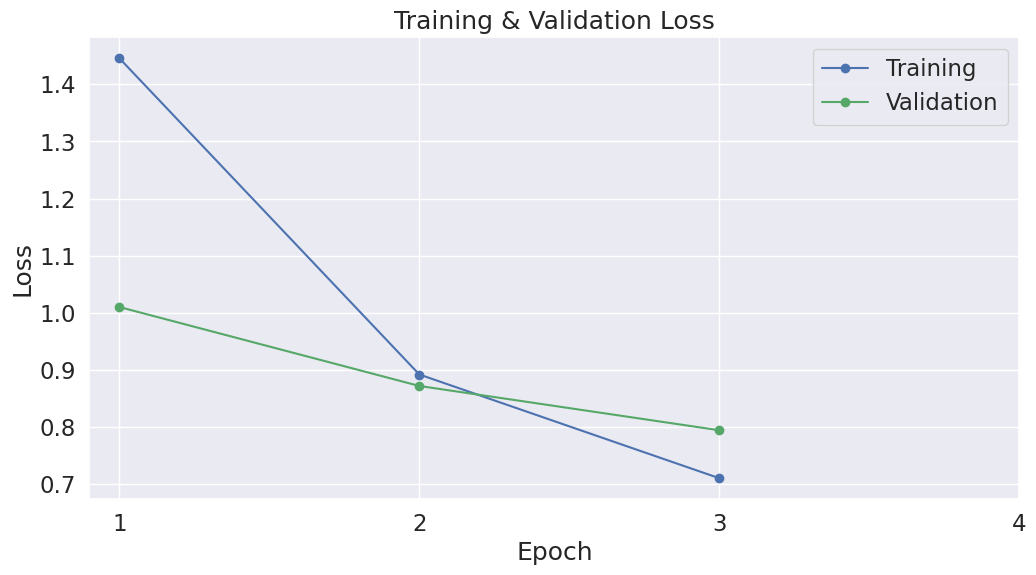

In [26]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [27]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [28]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '.'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')